In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import nose.tools as nt

# Needleman-Wunsch Algorithm

In [37]:
# From HW 1
UP = (-1,0)
LEFT = (0, -1)
TOPLEFT = (-1, -1)
ORIGIN = (0, 0)

def traceback_global(v, w, pointers):
    i,j = len(v), len(w)
    new_v = []
    new_w = []
    while True:
        di, dj = pointers[i][j]
        if (di,dj) == LEFT:
            new_v.append('-')
            new_w.append(w[j-1])
        elif (di,dj) == UP:
            new_v.append(v[i-1])
            new_w.append('-')
        elif (di,dj) == TOPLEFT:
            new_v.append(v[i-1])
            new_w.append(w[j-1])
        i, j = i + di, j + dj
        if (i <= 0 and j <= 0):
            break
    return ''.join(new_v[::-1])+'\n'+''.join(new_w[::-1])

def needleman_wunsch(v, w, delta):
    M = [[0 for j in range(len(w)+1)] for i in range(len(v)+1)]
    pointers = [[ORIGIN for j in range(len(w)+1)] for i in range(len(v)+1)]
    score, alignment = None, None

    for i in range(1, len(v) + 1):
      M[i][0] = M[i - 1][0] + delta[v[i - 1]]['-']
      pointers[i][0] = UP

    for j in range(1, len(w) + 1):
      M[0][j] = M[0][j - 1] + delta['-'][w[j - 1]]
      pointers[0][j] = LEFT

    for i in range(1, len(v) + 1):
      for j in range(1, len(w) + 1):
        scores = [M[i - 1][j - 1] + delta[v[i - 1]][w[j - 1]], M[i - 1][j] + delta[v[i - 1]]['-'], M[i][j - 1] + delta['-'][w[j - 1]]]
        M[i][j] = max(scores)
        if M[i][j] == scores[0]:
          pointers[i][j] = TOPLEFT
        elif M[i][j] == scores[1]:
          pointers[i][j] = UP
        else:
          pointers[i][j] = LEFT
    score = M[len(v)][len(w)]
    # --------------------------------------------
    alignment = traceback_global(v,w, pointers)
    return score, alignment

# Hirschberg's Algorithm

In [38]:
# Space-efficient function to calculate scores
def hirschberg_score(seq1, seq2, delta):
  # Store 2 columns at a time
  m = len(seq1)
  n = len(seq2)
  two_cols = [[0 for j in range(m + 1)] for i in range(2)]

  # Define an index to be either 0 or 1
  current = 0
  prev = 1
  # Iterate
  for row in range(n + 1):
    for col in range(m + 1):
      # Source must be 0
      if row == 0 and col == 0:
        two_cols[current][col] = 0
      elif row > 0 and col == 0:
        # Gap -> get result from previous row
        two_cols[current][col] = two_cols[prev][col] + delta[seq2[row - 1]]["-"]
      elif row == 0 and col > 0:
        # Gap -> get result from previous col
        two_cols[current][col] = two_cols[current][col - 1] + delta["-"][seq1[col - 1]]
      else:
        # Find max score
        one = two_cols[prev][col] + delta[seq2[row - 1]]["-"]
        two = two_cols[current][col - 1] + delta["-"][seq1[col - 1]]
        three = two_cols[prev][col - 1] + delta[seq2[row - 1]][seq1[col - 1]]
        val_arr = [one, two, three]
        two_cols[current][col] = max(val_arr)

    # Update indices
    if current == 0:
      current += 1
    elif current == 1:
      current -= 1
    if prev == 1:
      prev -= 1
    elif prev == 0:
      prev += 1

  # Return the element at (m, n)
  return two_cols[prev]

In [39]:
# Main function for Hirschberg
def hirschberg(seq1, seq2, delta):
    # Your Hirschberg implementation here
    # Define sequence lengths
    m = len(seq1)
    n = len(seq2)

    pairs = [(0, 0), (m, n)]
    # Call recursive function
    hirschberg_recursive(seq1, seq2, 0, 0, m, n, delta, pairs)
    # print(sorted(pairs))
    # Get the score
    output = hirschberg_score(seq1, seq2, delta)
    score = output[len(output) - 1]
    # print(output)
    # Get the backtrace and alignment
    alignment = traceback_global(seq1, seq2, hirschberg_backtrace(seq1, seq2, sorted(pairs), delta))

    return score, alignment

# Recursive function
def hirschberg_recursive(v, w, i, j, i_prime, j_prime, delta, pairs):
    # Helper function for recursion
    # From Lecture 5 slides
    if j_prime - j <= 1:
      return

    # Find i* and add to table
    new_j = int(j + (j_prime - j) / 2)

    # Calculate the prefix and suffix arrays
    prefixes = np.array(hirschberg_score(v[i:i_prime], w[j:new_j], delta))
    # Need to reverse for the suffix array
    suffixes = np.array(hirschberg_score(v[i:i_prime][::-1], w[new_j:j_prime][::-1], delta))

    # Find and maximize the weights
    wt = np.zeros(len(prefixes))
    for index in range(len(prefixes)):
        wt[index] = prefixes[index] + suffixes[-(index + 1)]

    i_star = np.argmax(wt) + i
    pairs.append((i_star, new_j))

    # Recursive calls
    hirschberg_recursive(v, w, i, j, i_star, new_j, delta, pairs)
    hirschberg_recursive(v, w, i_star, new_j, i_prime, j_prime, delta, pairs)

In [40]:
# Function to find the backtrace
# Input: points where Hirschberg splits the DP table
def hirschberg_backtrace(seq1, seq2, pairs, delta):
  # print(pairs)
  m = len(seq1)
  n = len(seq2)
  # From hirschberg_score
  two_cols = [[0 for j in range(m + 1)] for i in range(2)]
  pointers = [[ORIGIN for j in range(n + 1)] for i in range(m + 1)]
  # Define an index to be either 0 or 1
  current = 0
  prev = 1
  # Iterate
  for row in range(n + 1):
    for col in range(m + 1):
      # Source must be 0
      if row == 0 and col == 0:
        two_cols[current][col] = 0
      elif row > 0 and col == 0:
        # Gap -> get result from previous row
        two_cols[current][col] = two_cols[prev][col] + delta[seq2[row - 1]]["-"]
      elif row == 0 and col > 0:
        # Gap -> get result from previous col
        two_cols[current][col] = two_cols[current][col - 1] + delta["-"][seq1[col - 1]]
      else:
        # Check for a match and update using the max score
        one = two_cols[prev][col] + delta[seq2[row - 1]]["-"]
        two = two_cols[current][col - 1] + delta["-"][seq1[col - 1]]
        three = two_cols[prev][col - 1] + delta[seq2[row - 1]][seq1[col - 1]]
        val_arr = [one, two, three]
        two_cols[current][col] = max(val_arr)

    # Update indices
    if current == 0:
      current += 1
    elif current == 1:
      current -= 1
    if prev == 1:
      prev -= 1
    elif prev == 0:
      prev += 1

    # Check if all pairs have been added
    if row > 0 and pairs[row][0] - pairs[row - 1][0] <= 1:
      row_diff = pairs[row][0] - pairs[row - 1][0]
      col_diff = pairs[row][1] - pairs[row - 1][1]
      # Ensure that pairs are within range
      if row_diff == 0:
        pointers[pairs[row][0]][pairs[row][1]] = LEFT
      elif row_diff == 1 and col_diff == 0:
        pointers[pairs[row][0]][pairs[row][1]] = UP
      elif row_diff == 1 and col_diff == 1:
        pointers[pairs[row][0]][pairs[row][1]] = TOPLEFT
    elif row > 0:
      # Need to do a backtrace from pairs[row] to pairs[row - 1]
      top_row, top_col = pairs[row - 1]
      bot_row, bot_col = pairs[row]

      # Iterate
      curr = [top_row, top_col]
      # Store all possible paths from a starting point
      # Priority: TOPLEFT -> UP -> LEFT
      next = [curr]
      while True:
        # Get next row and col
        now = next.pop()
        curr_row, curr_col = now[0], now[1]

        if len(now) > 2:
          # Update backpointer
          pointers[curr_row][curr_col] = now[2]

        # Break if we're at the bottom right
        if curr_row == bot_row and curr_col == bot_col:
          break

        # LEFT
        if curr_col < bot_col and two_cols[prev][curr_row] == two_cols[current][curr_row] + delta["-"][seq2[curr_col]]:
          next.append([curr_row, bot_col, LEFT])

        # UP
        # Make sure we're in the same column
        if curr_col == bot_col:
          use = prev
        else:
          use = current
        if curr_row < bot_row and two_cols[use][curr_row + 1] == two_cols[use][curr_row] + delta[seq1[curr_row]]["-"]:
          next.append([curr_row + 1, curr_col, UP])

        # TOPLEFT
        if curr_row < bot_row and curr_col < bot_col and two_cols[prev][curr_row + 1] == two_cols[current][curr_row] + delta[seq1[curr_row]][seq2[curr_col]]:
          next.append([curr_row + 1, bot_col, TOPLEFT])

  return pointers

# Tests

## Simple Tests

In [41]:
# Define a delta
keys = ['A', 'C', 'T', 'G', '-']
delta = {}
for i in range(len(keys)):
    delta[keys[i]] = {k : v for (k,v) in zip(keys, [1 if keys[i] == keys[j]  else -1 for j in range(len(keys))])}

# Test 1
# From HW1
s = 'TG'
t = 'ATCG'
# (Score, Alignment)
print(f"Needleman-Wunsch: {needleman_wunsch(s, t, delta)}")
print(f"Hirschberg: {hirschberg(s, t, delta)}")


Needleman-Wunsch: (0, '-T-G\nATCG')
Hirschberg: (0, '-T-G\nATCG')


In [42]:
# Test 2
s = 'TAGATA'
t = 'GTAGGCTTAAGGTTA'
# (Score, Alignment)
print(f"Needleman-Wunsch: {needleman_wunsch(s, t, delta)}")
print(f"Hirschberg: {hirschberg(s, t, delta)}")

Needleman-Wunsch: (-3, '-TA-G----A---TA\nGTAGGCTTAAGGTTA')
Hirschberg: (-3, '-TA-G----A---TA\nGTAGGCTTAAGGTTA')


## Bacterial Sequences

In [43]:
# Instructions:
# Download human_mitochondrion.txt and rickettsiales_bacterium_excerpt.txt from Github
# Upload them into the Google Colab environment

# NCBI Sources:
# Mitochondrion: https://www.ncbi.nlm.nih.gov/nuccore/NC_012920.1?report=fasta
# Rickettsiales bacteria: https://www.ncbi.nlm.nih.gov/datasets/genome/GCA_024304995.1/

# Read the files
mito = ""
with open("human_mitochondrion.txt", "r") as file:
  arr = file.readlines()
  # Remove the first line
  arr.pop(0)
  # Add each line and remove the new line character
  for line in arr:
    mito += line.replace("\n", "")

ricket = ""
with open("rickettsiales_bacterium_excerpt.txt", "r") as file:
  arr = file.readlines()
  # Remove the first line
  arr.pop(0)
  # Add each line and remove the new line character
  for line in arr:
    ricket += line.replace("\n", "")

In [44]:
# Align the sequences
# First 100
print(f"Needleman-Wunsch:\n {needleman_wunsch(mito[:100], ricket[:100], delta)}")
print(f"Hirschberg:\n {hirschberg(mito[:100], ricket[:100], delta)}")

Needleman-Wunsch:
 (-4, '-------GA-TCACAGGTCTA-TCACCCTA-TTAACCACTCACGGGAGCT-CTCCATGCAT-TTGGTATT--T---T-CGTCTGGGGGGTATGCACGCGATA-GC-ATTGCGAGACGCTG\nCTGGGGGGAGTCA-GGGTGGAGTCA----AGGT-GGGGCGCAC--GAACTCCCCCCT-CATATT--TATTACTGAATACGT-TGAACTTTAT-TATG-AATATTCTA-TGC-TGA--C--')
Hirschberg:
 (-4, '-------GA-TCACAGGTCTA-TCACCCTA-TTAACCACTCACGGGAGCT-CTCCATGCAT-TTGGTATT--T---T-CGTCTGGGGGGTATGCACGCGATA-GC-ATTGCGAGACGCTG\nCTGGGGGGAGTCAG-GGTGGAGTCA----AGGTGGGG-CGCACGA-A-CTCCCCCCT-CATATT--TATTACTGAATACGT-TGAACTTTATT-ATGA-ATATTCTAT-GCT-GAC----')


In [45]:
# First 1000
print(f"Needleman-Wunsch:\n {needleman_wunsch(mito[:1000], ricket[:1000], delta)}")
print(f"Hirschberg:\n {hirschberg(mito[:1000], ricket[:1000], delta)}")

Needleman-Wunsch:
 (15, '-------GA-TCACAGGTCTA-TCACCCTA-TTAACCACTCACGGGAGCT-CTCCATGCAT-TTGGTATT--T---T-CGTCTGGGGGGTATGCACGCGATA-GC-AT--TG-C---GAGAC---GC-TG--GAGC-C-GGAGC--AC-CCT-ATG----TC-GCAGTATCTGTCTTTGATT--CC---TG-CCTCATCCTATTA-TTTATC-GCACCTAC-GTTCAATATTACA---G---G-C-GAACATACTTACTAAAG--TGTGT-T-AATTAATTAA--T-GCT-TGTAGGACAT-AATAATAACA-ATTGAATGTCTGCA-CAGC-CACTTTCCACACAGACATCATAACAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGC---ACTTAAACACATCTC-TGCCA-AACCCCAAAAACAAAGAACCCTAACACCAG-CCTAACCAGAT-TTCAAATT-T-TATCTTTTGGCGGTATGCACT-TTTA-ACAG--TCA-CCCCCCAAC-TAACACATTATT-TTC-CCCTC-CCACT--C-C---CA-TACTACTAATC---TCA--TCA-ATACA-ACCCCCGCC-CA--TCCTAC-CCAGCACACACACACCG-CTGCTAACCCCATACCCCGA--ACCAACCAA-ACCCCAAAGACACCCCCCACA-GTTTATGTAGCTTA-CCTCCTCAAAGCAATACACTGAAAATGTTTAGACGGGCTCACATCACCCCATAAACAAATAGGTT-TGGTCCTAGCCTTTCTATTAGCTCT-TAGTAAGATTACACATGCAAGCATCCCCGTTCCA-GTGAGTTCACCCT-CTAAATCACCACGATCAAAAGGAACAAG-CATCAAGCACGCAG-CA-ATGC-AGC-TC-AAAAC-GCTTAGCCTAGCCACACCCCCACGGGA--A-ACAGCAGTGATTAACCTTTAGCAAT-A-AACGAA

## Eukaryotic Sequences

In [46]:
# Instructions:
# Download human_mitochondrion.txt and rickettsiales_bacterium_excerpt.txt from Github
# Upload them into the Google Colab environment

# NCBI Sources:
# TP53: https://www.ncbi.nlm.nih.gov/gene/7157
# Telomerase reverse transcriptase (TERT): https://www.ncbi.nlm.nih.gov/gene/7015

# Read the files
tp53 = ""
with open("human_tp53.txt", "r") as file:
  arr = file.readlines()
  # Remove the first line
  arr.pop(0)
  # Add each line and remove the new line character
  for line in arr:
    tp53 += line.replace("\n", "")

tert = ""
with open("human_tert.txt", "r") as file:
  arr = file.readlines()
  # Remove the first line
  arr.pop(0)
  # Add each line and remove the new line character
  for line in arr:
    tert += line.replace("\n", "")

# Print lengths
print(len(tp53))
print(len(tert))

19070
41902


In [47]:
# Align the sequences
# First 500
print(f"Needleman-Wunsch:\n {needleman_wunsch(tp53[:500], tert[:500], delta)}")
print(f"Hirschberg:\n {hirschberg(tp53[:500], tert[:500], delta)}")

Needleman-Wunsch:
 (34, 'CTCAAAAGT-CTAGAGCCAC-CG-TCCAGG--GAGCAG-GTAGCTGCTGGGCTCCG-GGGACACTTTGCGTTCGGGCTGGGAGCGTGCTTTCCACGACGGTG--ACACGCT-TCC-CTG--GATTG-GGTAAGCT-CCTGACTGAACTTGATGAGTCCTCT-CTGAGTCACGG-GCT--CTC-GGCTC-CGTGTATTTTCAGC-TC-GGGAAAATCGCTGGGGCTGG-GGGTGGGGCA--GTGGGGACTTAGCGAG-TTT--G-G-G--GGT-G---AGTG---GGATG-G-AAG-CTTGGCTA-G-A-GG--GATCATCATAG-----GAGTT--G-CATTGTTGGG-AGACCTGGGTGT-AG-AT---GATGGGGATGTTAGGACCATCC-----GAACTCAAAGTTGA-ACGCCTAG-GCAGAGGAGTG-GAGCTTTGGG-GAACCTTGAGCCGGCCTAAAGCGTACTTCTTTGCACATCCACCCGGT-G-CTG-G-GC-GTAG-GGAATCCCTGAAATAAAAGATGCACAAAGCATTGAGGT-CTGAGACTTTTGG-ATCTCGAAACATTGA-GAA\nCTC-----TCCTCGCGGCGCGAGTTTCAGGCAGCGCTGCGT-CCTGCTGCGC-ACGTGGGA-A----GC---C---CTGGCCCCG-GCCACCCCCG-CGATGCCGCGCGCTCCCCGCTGCCGA--GCCGTGCGCTCCCTG-CTG--C--G--CAG-CCACTACCGCG--A-GGTGCTGCCGCTGGC-CACGT-T-CGTGCGGCGCCTGGG----GCCCCAGGGCTGGCGGCTGGTGCAGCGCGGGGACCCGGCG-GCTTTCCGCGCGCTGGTGGCCCAGTGCCTGG-TGTGCGTGCCCTGG-GACGCACGGCCGCCCCCCGCCGCCCCCTCCTTCCGCCA--GGTGGGCCTCCCCGGG-GTCGGCGTCCGGCTGGGG-T-TGAGG-GCGGCCG

In [48]:
# Align the sequences
# Takeaway: Same sequences, but different alignments also possible depending on implementation
# First 5000
print(f"Needleman-Wunsch:\n {needleman_wunsch(tp53[:5000], tert[:5000], delta)}")
print(f"Hirschberg:\n {hirschberg(tp53[:5000], tert[:5000], delta)}")

Needleman-Wunsch:
 (248, 'CTCAAAAGT-CTAGAGCCAC-CG-TCCAGG--GAGCAG-GTAGCTGCTGGGCTCCG-GGGACACTTTGCGTTCGGGCTGGGAGCGTGCTTTCCACGACGGTG--ACACGCT-TCC-CTG--GATTG-GGTAAGCT-CCTGACTGAACTTGATGAGTCCTCT-CTGAGTCACGG-GCT--CTC-GGCTC-CGTGTATTTTCAGC-TC-GGGAAAATCGCTGGGGCTGG-GGGTGGGGCA--GTGGGGACTTAGCGAG-TTT--G-G-G--GGT-G---AGTG---GGATG-G-AAG-CTTGGCTA-G-A-GG--GATCATCATAG-----GAGTT--G-CATTGTTGGG-AGACCTGGGTGT-AG-AT---GATGGGGATGTTAGGACCATCC-----GAACTCAAAGTTGA-ACGCCTAG-GCAGAGGAGTG-GAGCTTTGGG-G--AACCTTG-A---G-CCGGCCTAAAGCGTA-CTTCTTTGCAC-A-TCCACCCG-GTGCTGGGCGTAGGGAATCCCTGAAATAAAAGATGCACAAAGCATT-GAG-GTCTGAGACTTTTGGATCTCGAAACATTGAGAACTCATAGCTGTA-TATTTTA-GAGCC--CATG-GCATCCTA-GTG-AAAACTGGGGCTCCATTCCGAAATGATCATTTG-GGGGTGATC----CG-GGGAGC-CCAAGCTGCTAAG-GT--CCCACAAC-TTCCGG---ACCT-TTGTC-CTTCCTGGAGCGATCTTTCCAG-GCAGCCCCCGGCTCCGCTAGATGGAGAAAATCCA-AT-TGAAGGCTGTCAGTCGTGGA--AG-T-GAGAAG-TGCTAAAC-CAGG---GGTTTGCCCGCCAGGC-CGAGGAGGACCGTCGCAA----TCT--GA---G-A--GGCCCGGCAGCCCT---GTTA---TTGTTTGGCTCCACATTTACATTTCTGCCTC--TTGCAGCAGCATTTC-CG

# Visualization

In [11]:
!pip install memory-profiler

In [12]:
%load_ext memory_profiler
from memory_profiler import profile

In [14]:
chars = ['A', 'G', 'C', 'T']
sequence_lengths, needleman_wunsch_memory, hirschberg_memory = [], [], []

for i in range(0, 5501, 500):
    seq1 = ''.join(np.random.choice(chars) for _ in range(i))
    seq2 = ''.join(np.random.choice(chars) for _ in range(i))

    print(i)

    b = %memit -o pass
    x = %memit -o needleman_wunsch(seq1, seq2, delta)
    y = %memit -o hirschberg(seq1, seq2, delta)

    sequence_lengths.append(i)
    needleman_wunsch_memory.append(x.mem_usage[0] - b.baseline)
    hirschberg_memory.append(y.mem_usage[0] - b.baseline)

0
peak memory: 141.34 MiB, increment: 0.00 MiB
peak memory: 141.45 MiB, increment: 0.00 MiB
peak memory: 141.45 MiB, increment: 0.00 MiB
500
peak memory: 141.71 MiB, increment: 0.00 MiB
peak memory: 150.77 MiB, increment: 8.99 MiB
peak memory: 148.23 MiB, increment: 0.06 MiB
1000
peak memory: 148.24 MiB, increment: 0.00 MiB
peak memory: 178.84 MiB, increment: 30.59 MiB
peak memory: 157.59 MiB, increment: 4.48 MiB
1500
peak memory: 153.31 MiB, increment: 0.00 MiB
peak memory: 224.25 MiB, increment: 70.94 MiB
peak memory: 172.38 MiB, increment: 13.28 MiB
2000
peak memory: 158.23 MiB, increment: 0.00 MiB
peak memory: 286.48 MiB, increment: 128.24 MiB
peak memory: 190.91 MiB, increment: 9.03 MiB
2500
peak memory: 180.92 MiB, increment: 0.00 MiB
peak memory: 369.02 MiB, increment: 188.10 MiB
peak memory: 219.16 MiB, increment: 26.52 MiB
3000
peak memory: 191.84 MiB, increment: 0.00 MiB
peak memory: 481.62 MiB, increment: 289.79 MiB
peak memory: 255.62 MiB, increment: 50.68 MiB
3500
peak mem

In [15]:
print(needleman_wunsch_memory, hirschberg_memory)

[0.11328125, 9.05859375, 30.59375, 70.94140625, 128.2421875, 188.1015625, 289.78515625, 413.5390625, 545.59765625, 717.40234375, 599.2578125, 814.60546875] [0.11328125, 6.5234375, 9.34375, 19.07421875, 32.6796875, 38.234375, 63.78515625, 92.08984375, 123.33203125, 324.4375, 32.45703125, 39.55078125]


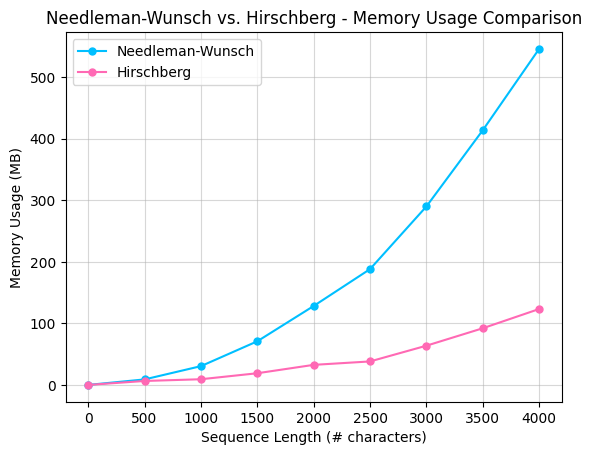

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(sequence_lengths[0:9], needleman_wunsch_memory[0:9], marker='o', markersize=5, label='Needleman-Wunsch', color='deepskyblue')
plt.plot(sequence_lengths[0:9], hirschberg_memory[0:9], marker='o', markersize=5, label='Hirschberg', color='hotpink')

plt.title('Needleman-Wunsch vs. Hirschberg - Memory Usage Comparison')
plt.xlabel('Sequence Length (# characters)')
plt.ylabel('Memory Usage (MB)')
plt.legend()
plt.grid(which='both', alpha=0.5)

plt.legend()
plt.show()

In [32]:
import pandas as pd

# Creating a DataFrame
data = {
    'Sequence Length (# characters)': sequence_lengths[0:9],
    'Needleman-Wunsch memory (MB)': needleman_wunsch_memory[0:9],
    'Hirschberg memory (MB)': hirschberg_memory[0:9]
}

df = pd.DataFrame(data)
df.style.hide_index()

<ipython-input-32-643d8928fa62>:11: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df.style.hide_index()


Sequence Length (# characters),Needleman-Wunsch memory (MB),Hirschberg memory (MB)
0,0.113281,0.113281
500,9.058594,6.523438
1000,30.593750,9.343750
1500,70.941406,19.074219
2000,128.242188,32.679688
2500,188.101562,38.234375
3000,289.785156,63.785156
3500,413.539062,92.089844
4000,545.597656,123.332031
